# PART 3: Change detection on time series of Sentinel-2 images

* **Using**: [RaVAEn](https://github.com/spaceml-org/RaVAEn/) and baseline methods

* **Note**: This notebook will need GPU (select it as a run time on Colab).

This notebook shows how to run our RaVAEn model for unsupervised change detection.

In [ ]:
# Install libraries relevant for Colab
!pip install --quiet --upgrade gdown
!pip install --quiet hydra-core==1.1.0 kornia rasterio wandb pandas seaborn sklearn
!pip install --quiet pytorch_lightning==1.3.8
!pip install torchmetrics==0.5.1

In [2]:
!pip install matplotlib==3.5.1 numpy==1.21.1 Pillow==8.3.1
# please restart the runtime after these!

     |████████████████████████████████| 11.2 MB 5.4 MB/s 
     |████████████████████████████████| 15.7 MB 248 kB/s 
     |████████████████████████████████| 3.0 MB 25.9 MB/s 
     |████████████████████████████████| 900 kB 37.2 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
datascience 0.10.6 requires f

In [1]:
!pip -q install rasterio

     |████████████████████████████████| 19.3 MB 1.3 MB/s 


In [ ]:
# Make sure you are connected to a Colab with GPU:
!nvidia-smi

Mon Apr 18 19:04:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    35W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Version A: data we downloaded in the last notebook

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls /content/drive/MyDrive/RaVAEn_DEMO_S2_*.tif -luah

-rw------- 1 root root 17M Jan  1  1970 /content/drive/MyDrive/RaVAEn_DEMO_S2_20210418.tif
-rw------- 1 root root 17M Jan  1  1970 /content/drive/MyDrive/RaVAEn_DEMO_S2_20210531.tif
-rw------- 1 root root 17M Jan  1  1970 /content/drive/MyDrive/RaVAEn_DEMO_S2_20220227.tif
-rw------- 1 root root 17M Jan  1  1970 /content/drive/MyDrive/RaVAEn_DEMO_S2_20220317.tif
-rw------- 1 root root 17M Jan  1  1970 /content/drive/MyDrive/RaVAEn_DEMO_S2_20220416.tif


In [4]:
!cp /content/drive/MyDrive/RaVAEn_DEMO_S2_*.tif .

## Version B: data from the disaster dataset

In [6]:
# datasets
!mkdir /content/datasets
%cd /content/datasets

"""
!gdown https://drive.google.com/uc?id=1CbNGrpK66Hos_TtOEut510k7CSHvSwkl -O landslides.zip
!unzip -q landslides.zip
!rm landslides.zip
"""

# """
!gdown https://drive.google.com/uc?id=1scjd4gIB_eiNS-CsOyb7Q8rYWnl9TM-L -O floods.zip
!unzip -q floods.zip
!rm floods.zip
# """

pass

/content/datasets
Downloading...
From: https://drive.google.com/uc?id=1scjd4gIB_eiNS-CsOyb7Q8rYWnl9TM-L
To: /content/datasets/floods.zip
100% 2.64G/2.64G [00:18<00:00, 139MB/s]


In [7]:
%cd /content/

/content


## Simple image differencing methods


In [8]:
!ls

datasets		     RaVAEn_DEMO_S2_20220227.tif
drive			     RaVAEn_DEMO_S2_20220317.tif
RaVAEn_DEMO_S2_20210418.tif  RaVAEn_DEMO_S2_20220416.tif
RaVAEn_DEMO_S2_20210531.tif  sample_data


In [9]:
!ls ./datasets/floods/EMSR260_02VIADANA/S2/

2017-11-18.tif	2017-11-30.tif	2017-12-03.tif	2017-12-05.tif	2017-12-13.tif


In [10]:
from glob import glob
# s2_files = glob("./RaVAEn_DEMO_S2_*.tif") # < version A, the data we just downloaded
s2_files = glob("./datasets/floods/EMSR260_02VIADANA/S2/*.tif") # < version B data from an example flood
s2_files.sort()
s2_files

['./datasets/floods/EMSR260_02VIADANA/S2/2017-11-18.tif',
 './datasets/floods/EMSR260_02VIADANA/S2/2017-11-30.tif',
 './datasets/floods/EMSR260_02VIADANA/S2/2017-12-03.tif',
 './datasets/floods/EMSR260_02VIADANA/S2/2017-12-05.tif',
 './datasets/floods/EMSR260_02VIADANA/S2/2017-12-13.tif']

In [11]:
#@title init functions from previous notebook

import rasterio
import numpy as np
import rasterio.plot as rstplt
import matplotlib.pyplot as plt

size_read = 600
with rasterio.open(s2_files[0]) as src:
    width = src.width
    height = src.height

    # Compute shape to read to from pyramids and speed up plotting
    shape = src.shape
    if (size_read >= shape[0]) and (size_read >= shape[1]):
      out_shape = shape
    elif shape[0] > shape[1]:
      out_shape = (size_read, int(round(shape[1]/shape[0] * size_read)))
    else:
      out_shape = (int(round(shape[0] / shape[1] * size_read)), size_read)


# Normalized Difference Vegetation Index
# Source: https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/ndvi/#
def calculate_ndvi(red, nir):
    ndvi = ((nir - red)/(nir + red))
    # ndvi = (B08 - B04) / (B08 + B04);
    return ndvi

def ndvi_pix2color(ndvi):
  # Visualization, as used in EO Browser:
  # source https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/ndvi/
  # ndvi pixel value to rgb colour
  if (ndvi<-1.1): return [0,0,0]
  elif (ndvi<-0.2): return [0.75,0.75,0.75]
  elif (ndvi<-0.1): return [0.86,0.86,0.86]
  elif (ndvi<0): return [1,1,0.88]
  elif (ndvi<0.025): return [1,0.98,0.8]
  elif (ndvi<0.05): return [0.93,0.91,0.71]
  elif (ndvi<0.075): return [0.87,0.85,0.61]
  elif (ndvi<0.1): return [0.8,0.78,0.51]
  elif (ndvi<0.125): return [0.74,0.72,0.42]
  elif (ndvi<0.15): return [0.69,0.76,0.38]
  elif (ndvi<0.175): return [0.64,0.8,0.35]
  elif (ndvi<0.2): return [0.57,0.75,0.32]
  elif (ndvi<0.25): return [0.5,0.7,0.28]
  elif (ndvi<0.3): return [0.44,0.64,0.25]
  elif (ndvi<0.35): return [0.38,0.59,0.21]
  elif (ndvi<0.4): return [0.31,0.54,0.18]
  elif (ndvi<0.45): return [0.25,0.49,0.14]
  elif (ndvi<0.5): return [0.19,0.43,0.11]
  elif (ndvi<0.55): return [0.13,0.38,0.07]
  elif (ndvi<0.6): return [0.06,0.33,0.04]
  else: return [0,0.27,0]

# Let's prepare this fast function for later...
def img2_ndvi_viz(img, return_visualization=True):
  ndvi = calculate_ndvi(img[3], img[7])
  if return_visualization:
    return np.asarray([[ndvi_pix2color(pixel) for pixel in row] for row in ndvi])
  else:
    return ndvi

In [12]:
images = []
ndvis = []

for i, s2_file in enumerate(s2_files):
  with rasterio.open(s2_file) as src:
    img = src.read(out_shape=out_shape)

  images.append(img)
  ndvi = img2_ndvi_viz(img, return_visualization=False)
  ndvis.append(ndvi)

images = np.asarray(images)
ndvis = np.asarray(ndvis)

print("Loaded:")
print(images.shape)
print(ndvis.shape)

Loaded:
(5, 15, 495, 600)
(5, 495, 600)


Lets look at the sequence with RGB bands:

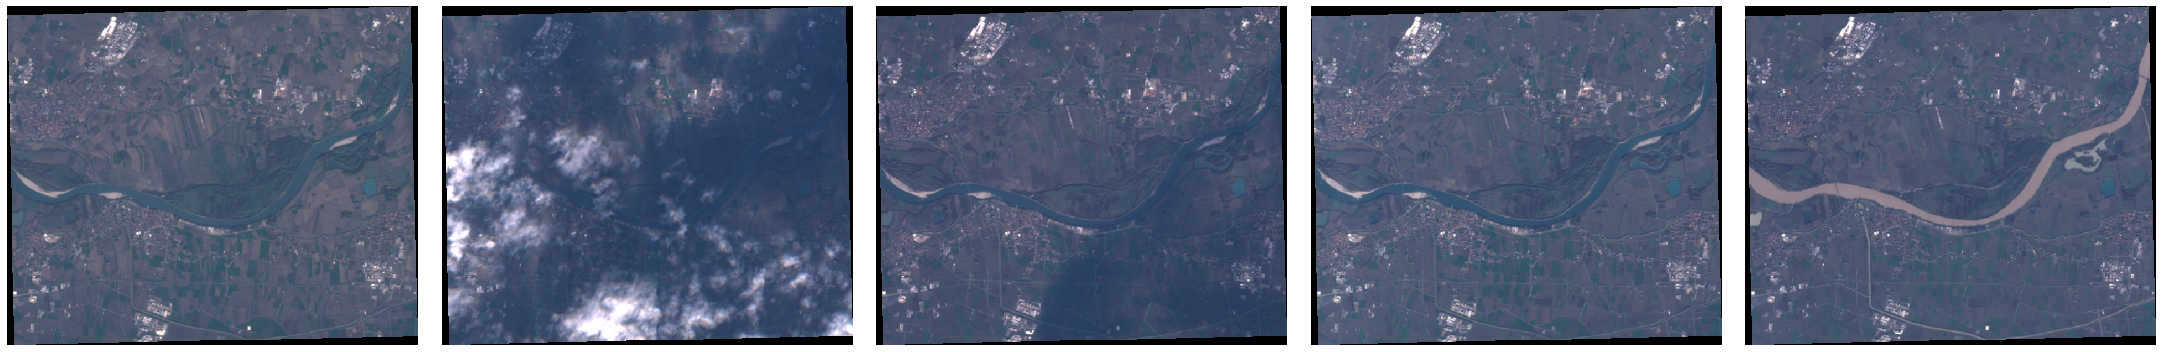

In [13]:
n_plots = len(ndvis)
fig, ax = plt.subplots(1, n_plots, figsize=(n_plots*5*width/height,5), tight_layout=True)
  
# RGB
for i, img in enumerate(images):
  img = np.clip(img[[3,2,1]]/3000., 0, 1)
  rstplt.show(img, ax=ax[i])
  ax[i].axis("off")
plt.show()

Basic image differencing just subtracts the two images.

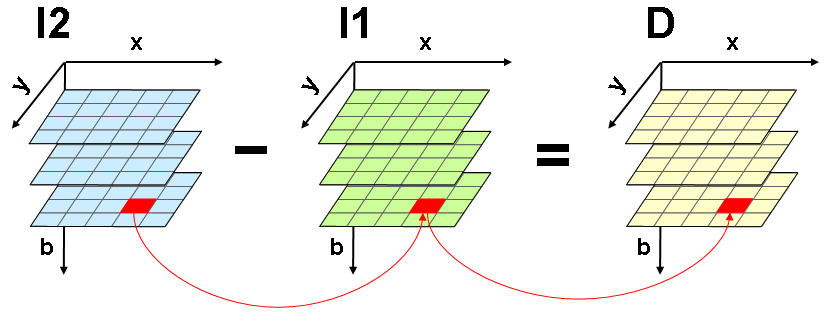


### By default we can do this using just the raw pixel data:

<big>**TASK 3: <font color="blue">Implement image differencing**</blue></big>


In [14]:
def image_differencing(before, after):
  # Task 3: implement image differencing here
  # - hint: remember to normalize the data
  # - hint: use only selected bands (for example only the RGB bands)
  # - the subtraction of the two images will give you a difference image with the same number of bands
  #   you can use the np.axam function to always select the maximal value across bands

  # TODO!

  return diff_img

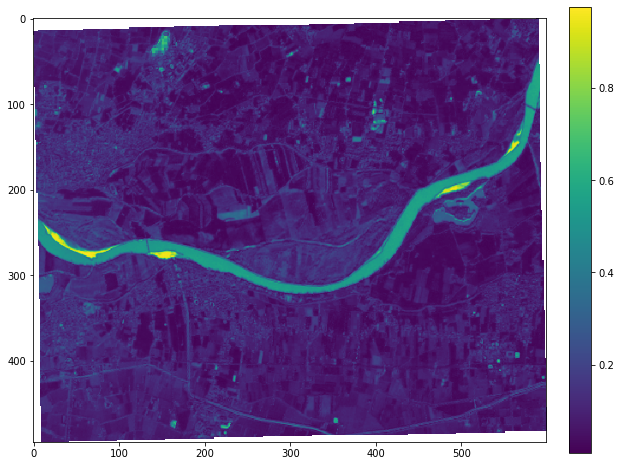

In [15]:
# Looking just at the last two:
n_plots = len(images)-1

before = images[n_plots-1]
after = images[n_plots]

diff_img = image_differencing(before, after)

plt.figure(figsize=(10,10))
plt.imshow(diff_img)
plt.colorbar(fraction=0.04, pad=0.04)
plt.show()

Now would this work for all images in the sequence?

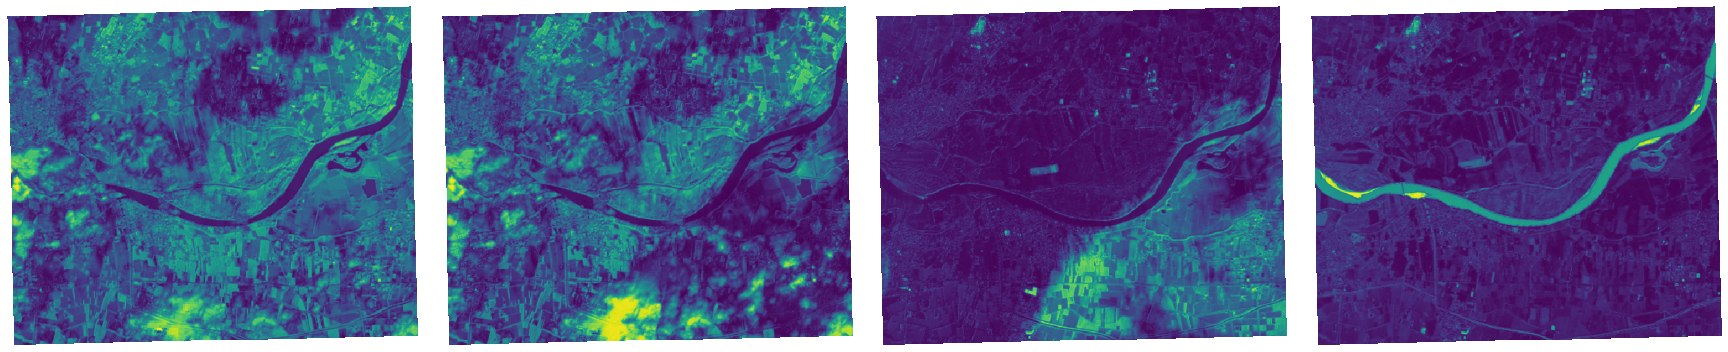

In [16]:
n_plots = len(images)
fig, ax = plt.subplots(1, n_plots, figsize=(n_plots*5*width/height,5), tight_layout=True)

# choose one here
allowed_bands = list(range(0,13)) # we better skip the last 14th band
# allowed_bands = [3,2,1] # or only RGB

# rgb's
for i in range(0,n_plots):
  if i==0:
    ax[i].set_visible(False)
    continue

  before = images[i-1]
  after = images[i]
  diff_img = image_differencing(before, after)

  rstplt.show(diff_img, ax=ax[i])
  ax[i].axis("off")

plt.show()

### Using the calculated indices:

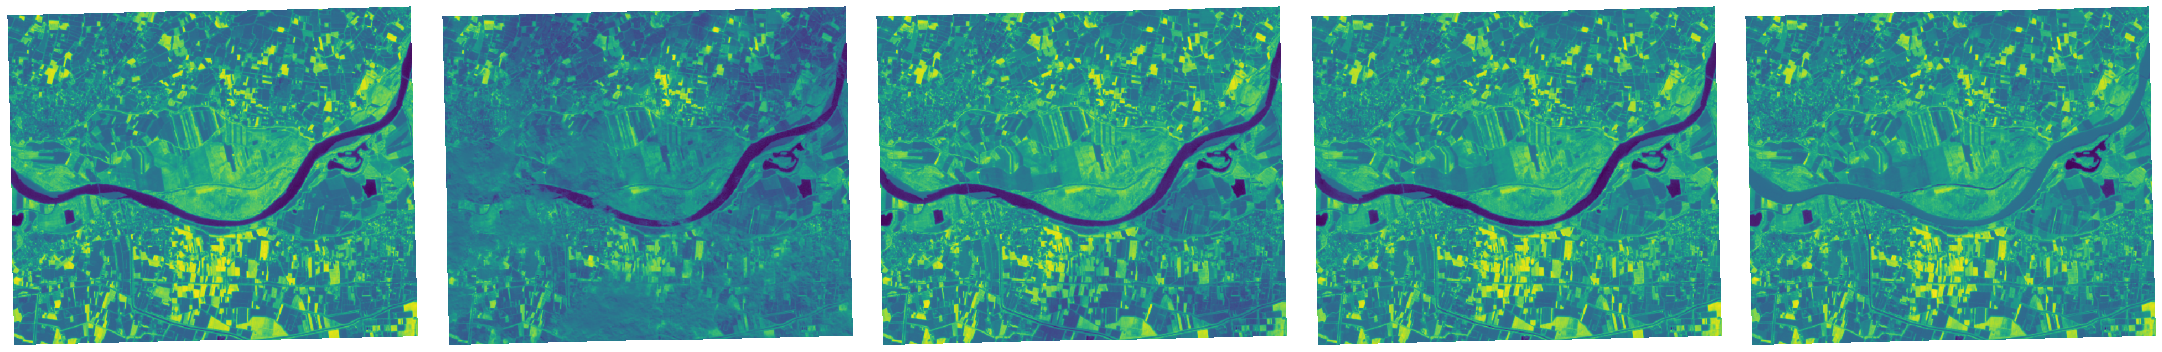

In [ ]:
n_plots = len(ndvis)
fig, ax = plt.subplots(1, n_plots, figsize=(n_plots*5*width/height,5), tight_layout=True)
  
# ndvi's
for i, img in enumerate(ndvis):
  rstplt.show(img, ax=ax[i])
  ax[i].axis("off")
plt.show()

When comparing only the two calculated NDVI's:

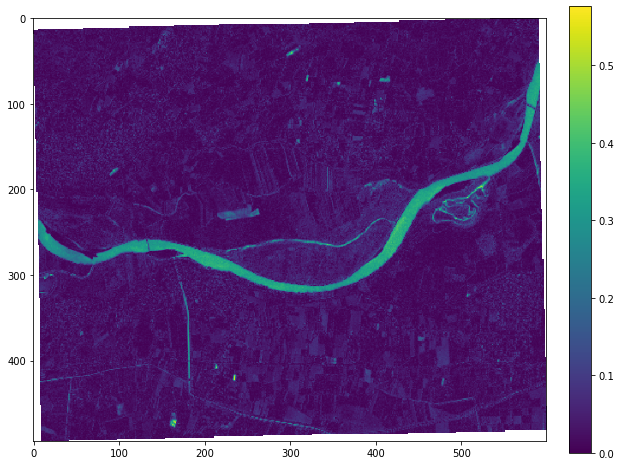

In [ ]:
# Looking just at the last two:
n_plots = len(images)-1

# Difference image here:
diff_img = abs(ndvis[n_plots-1] - ndvis[n_plots])

plt.figure(figsize=(10,10))
plt.imshow(diff_img)
plt.colorbar(fraction=0.04, pad=0.04)
plt.show()

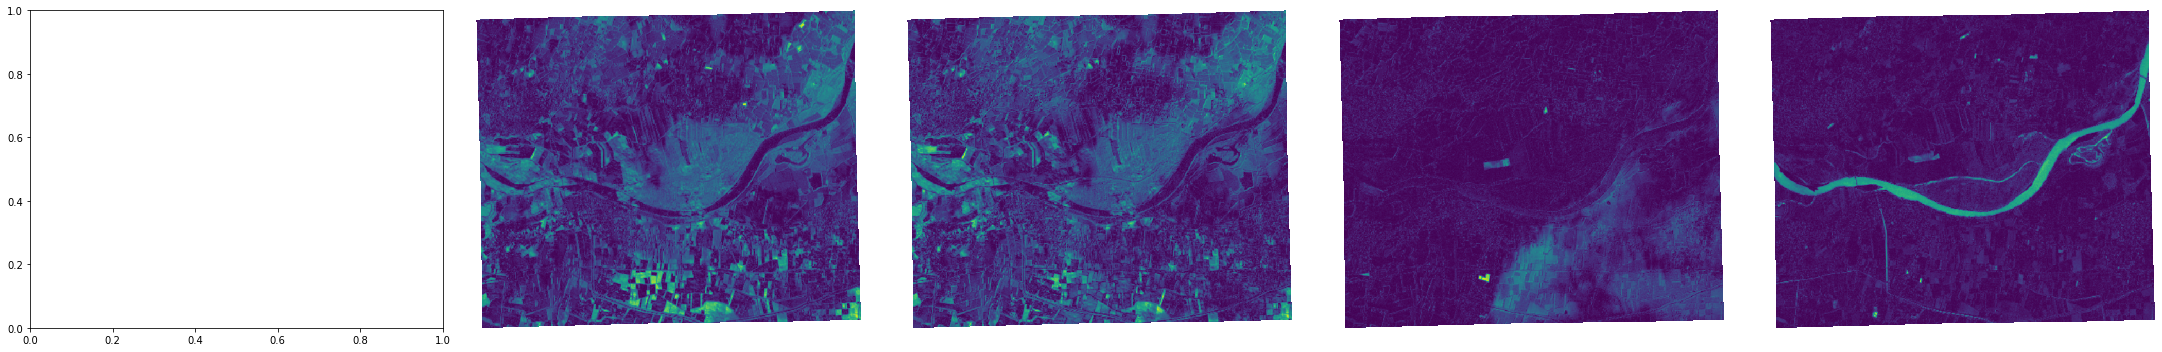

In [ ]:
n_plots = len(ndvis)
fig, ax = plt.subplots(1, n_plots, figsize=(n_plots*5*width/height,5), tight_layout=True)
  
# ndvi differences
for i in range(1,n_plots):
  if i==0:
    ax[i].set_visible(False)
    continue
  diff_img = abs(ndvis[i] - ndvis[i-1])
  rstplt.show(diff_img, ax=ax[i])
  ax[i].axis("off")
plt.show()

In practice, it can be quite hard to distinguish an actual change from background noise regardless of the manual technique - the image differencing techniques tend to be quite sensitive to noise and sensor jitter!

# Using our pre-trained RaVAEn model!

In [ ]:
!mkdir datasets/
!mkdir datasets/downloaded_maps/
!mkdir datasets/downloaded_maps/location/
!mkdir datasets/downloaded_maps/location/S2
!mkdir datasets/downloaded_maps/location/changes

In [ ]:
# Version A: using the downloaded data
# !mv *.tif datasets/downloaded_maps/location/S2

# Version B: using the flood data
!cp datasets/floods/EMSR260_02VIADANA/S2/*.tif datasets/downloaded_maps/location/S2

In [ ]:
!ls datasets/downloaded_maps/location/S2 -l

total 171984
-rwxr-xr-x 1 root root 35091858 Apr 18 19:06 2017-11-18.tif
-rwxr-xr-x 1 root root 35471515 Apr 18 19:06 2017-11-30.tif
-rwxr-xr-x 1 root root 35006813 Apr 18 19:06 2017-12-03.tif
-rwxr-xr-x 1 root root 35575709 Apr 18 19:06 2017-12-05.tif
-rwxr-xr-x 1 root root 34954240 Apr 18 19:06 2017-12-13.tif


In [ ]:
import rasterio
from rasterio.plot import show
import numpy as np
from pylab import plt

def visualize_rgb(tif_path, cut_off_value = 2000, show=False, save="tmp.png", force_process_all=False):
    plot = plt.figure(figsize=(8, 6), dpi=200)
    
    # Open and read RGB bands
    src = rasterio.open(tif_path) # Can I open fast in lower resolution?
    print("opening ~ ", src.width, src.height, src)

    image_rgb = src.read([4,3,2]) # src.read(window=window) would loot at a corner only ...
    red, green, blue = image_rgb

    # Threshold to deal with outliers
    red[red>cut_off_value] = cut_off_value
    blue[blue>cut_off_value] = cut_off_value
    green[green>cut_off_value] = cut_off_value

    # Scale bands
    red = (rasterio.plot.adjust_band(red, kind='linear')*255).astype(np.uint8)
    green = (rasterio.plot.adjust_band(green, kind='linear')*255).astype(np.uint8)
    blue = (rasterio.plot.adjust_band(blue, kind='linear')*255).astype(np.uint8)
    
    array = np.stack([red, green, blue], axis=0) # returns (3, 1497, 1698)
    resolution = array.shape

    rasterio.plot.show(array)
    plot.tight_layout()
    plt.axis('off')

    if show:
        plot.show() # only on non-vm machines
    if save:
        plot.savefig(save)
        
    return plot, resolution


In [ ]:
# Our code repository needs a GT file, we can make an empty one
import glob
tif_files = glob.glob("/content/datasets/downloaded_maps/location/S2/*.tif")
last_name = tif_files[-1].split("/")[-1]

src = rasterio.open(tif_files[-1])
print("opening ~ ", src.width, src.height, src)
empty_array = np.zeros((src.height, src.width))

file_name = "/content/datasets/downloaded_maps/location/changes/"+last_name

with rasterio.Env():
    profile = src.profile
    profile.update(
        count=1,
    )

    with rasterio.open(file_name, 'w', **profile) as dst:
        dst.write(empty_array.astype(rasterio.uint8), 1)

print("made", file_name)

opening ~  1042 859 <open DatasetReader name='/content/datasets/downloaded_maps/location/S2/2017-12-13.tif' mode='r'>
made /content/datasets/downloaded_maps/location/changes/2017-12-13.tif


In [ ]:
!ls /content/datasets/downloaded_maps/location/changes/ -luah

total 28K
drwxr-xr-x 2 root root 4.0K Apr 18 19:06 .
drwxr-xr-x 4 root root 4.0K Apr 18 19:06 ..
-rw-r--r-- 1 root root  18K Apr 18 19:06 2017-12-13.tif


## 1 Code and models prep

In [ ]:
%cd /content/
!git clone https://github.com/spaceml-org/RaVAEn.git

/content
Cloning into 'RaVAEn'...
remote: Enumerating objects: 153, done.
remote: Counting objects: 100% (153/153), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 153 (delta 34), reused 153 (delta 34), pack-reused 0
Receiving objects: 100% (153/153), 3.94 MiB | 4.23 MiB/s, done.
Resolving deltas: 100% (34/34), done.


In [ ]:
# pretrained models
!mkdir /content/pretrained
%cd /content/pretrained

# download one model (23MB) setting with the code below (or alternatively download all the released models (138MB) from https://drive.google.com/file/d/12AwpGu7El1FWP7ErFBQ9sfuTzl2L-dT4/view?usp=sharing )
!gdown https://drive.google.com/uc?id=1LcOMmWxYSBUrH_HS747FGkhr2ZuS_y8v -O pretrained_small.zip
!unzip -q pretrained_small.zip
!rm pretrained_small.zip

%cd /content/

## 2 Inference

In [ ]:
%cd /content/RaVAEn/
!ls

/content/RaVAEn
bash	    docs	    LICENSE    README.md  src
config	    env.yaml	    Makefile   scripts	  test_environment.py
deployment  _illustrations  notebooks  setup.py   tox.ini


In [ ]:
# Edit the config programatically for Colab
p = """
---
entity: "mlpayloads"

log_dir: "/content/results"
cache_dir: "/content/cache"
"""

c = """text_file = open("config/config.yaml", "w+");text_file.write(p);text_file.close()""" 
exec(c)

In [ ]:
!cat config/config.yaml
"""
Fill in:
log_dir: "/content/results"
cache_dir: "/content/cache"
"""
pass


---
entity: "mlpayloads"

log_dir: "/content/results"
cache_dir: "/content/cache"


In [ ]:
!mkdir /content/results
!mkdir /content/results/wandb/
!mkdir /content/results/cache/

The next code can take some time (approx. between 5 to 10 mins) and will need you to choose where to save results (either only locally, or also on the weights and biases webpage).

In [ ]:
# ===== Parameters to adjust =====
# Note: adjust these to where you downloaded the datasets and the pretrained models

event="downloaded_maps"
checkpoint="/content/pretrained/D_train_VAE_128small/3k0vhd2o/checkpoints/epoch_00-step_29653.ckpt"
dataset_root_folder = "/content/datasets/" + event

name="VAE_128small_3k0vhd2o_epoch0___DemoInferenceOnColab"

# ===== Parameters to keep the same ======

evaluation="vae_paper"
training="simple_vae"
module="deeper_vae"
plot_sequences="true"

# ========================================

!python3 -m scripts.evaluate_model \
    +dataset=floods_evaluation \
    ++dataset.root_folder=$dataset_root_folder \
    +training=$training \
    +normalisation=log_scale \
    +channels=high_res \
    +module=$module \
    +checkpoint=$checkpoint \
    +project="ColabDEMO_eval_paper_VAE_128small" \
    +evaluation=$evaluation \
    ++evaluation.plot_sequences=$plot_sequences \
    +name="{name}_{event}" \
    +dataset.test_overlap=[0,0] module.model_cls_args.latent_dim=128 module.model_cls_args.extra_depth_on_scale=0 module.model_cls_args.hidden_channels=[16,32,64] \
    ++evaluation.save_plots_locally=true \
    training.num_workers=2 training.batch_size_train=64 training.batch_size_valid=64 training.batch_size_test=64

    # the last few args set the same architecture as the one we used when training
    # and some hw specs settings:
    # training.num_workers=2 training.batch_size_train=64 training.batch_size_valid=64 training.batch_size_test=64


LATENT SPACE size: 128
Loading checkpoint /content/pretrained/D_train_VAE_128small/3k0vhd2o/checkpoints/epoch_00-step_29653.ckpt
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/saving.py:349: RuntimeWarning: Missing Tags: /content/pretrained/D_train_VAE_128small/3k0vhd2o/hparams.yaml.
  rank_zero_warn(f"Missing Tags: {config_yaml}.", RuntimeWarning)

LATENT SPACE size: 128
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: 3
wandb: You chose 'Don't visualize my results'
wandb: WARNING `resume` will be ignored since W&B syncing is set to `offline`. Starting a new run with run id prphgbmm.
wandb: Tracking run with wandb version 0.12.14
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.
Will save results locally: True (otherwise these will only be sent to Wandb).
  0% 0/1 [00:00<?, ?it/s]
Populating data:   

## 3 Results

Results are best to be observed on the generated Wandb page, however there are also local files saved which we can observe.

In [ ]:
!ls outputs/*.csv

outputs/000_stats.csv


Note that we have results corresponding to all of the above csv files. Just select one by setting ``` index = 0 ``` (1,2, etc...).



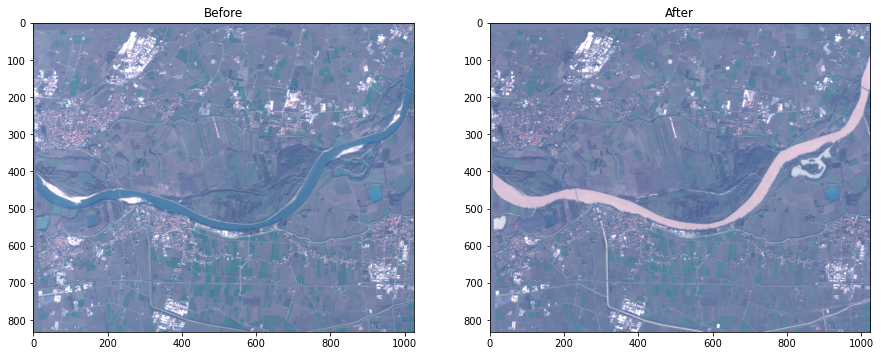

In [ ]:
import matplotlib.pyplot as plt

# Select the index of the desired event
index = 0

# Event visualization

plt.figure(figsize=(15,15))
plt.subplot(1, 2, 1)
img = plt.imread("./outputs/"+str(index).zfill(3)+"_1_before.png")
plt.imshow(img)
plt.gca().set_title('Before')

plt.subplot(1, 2, 2)
img = plt.imread("./outputs/"+str(index).zfill(3)+"_2_after.png")
plt.imshow(img)
plt.gca().set_title('After')

plt.show()

Baseline (pixel values in cosine distance, with memory 3)


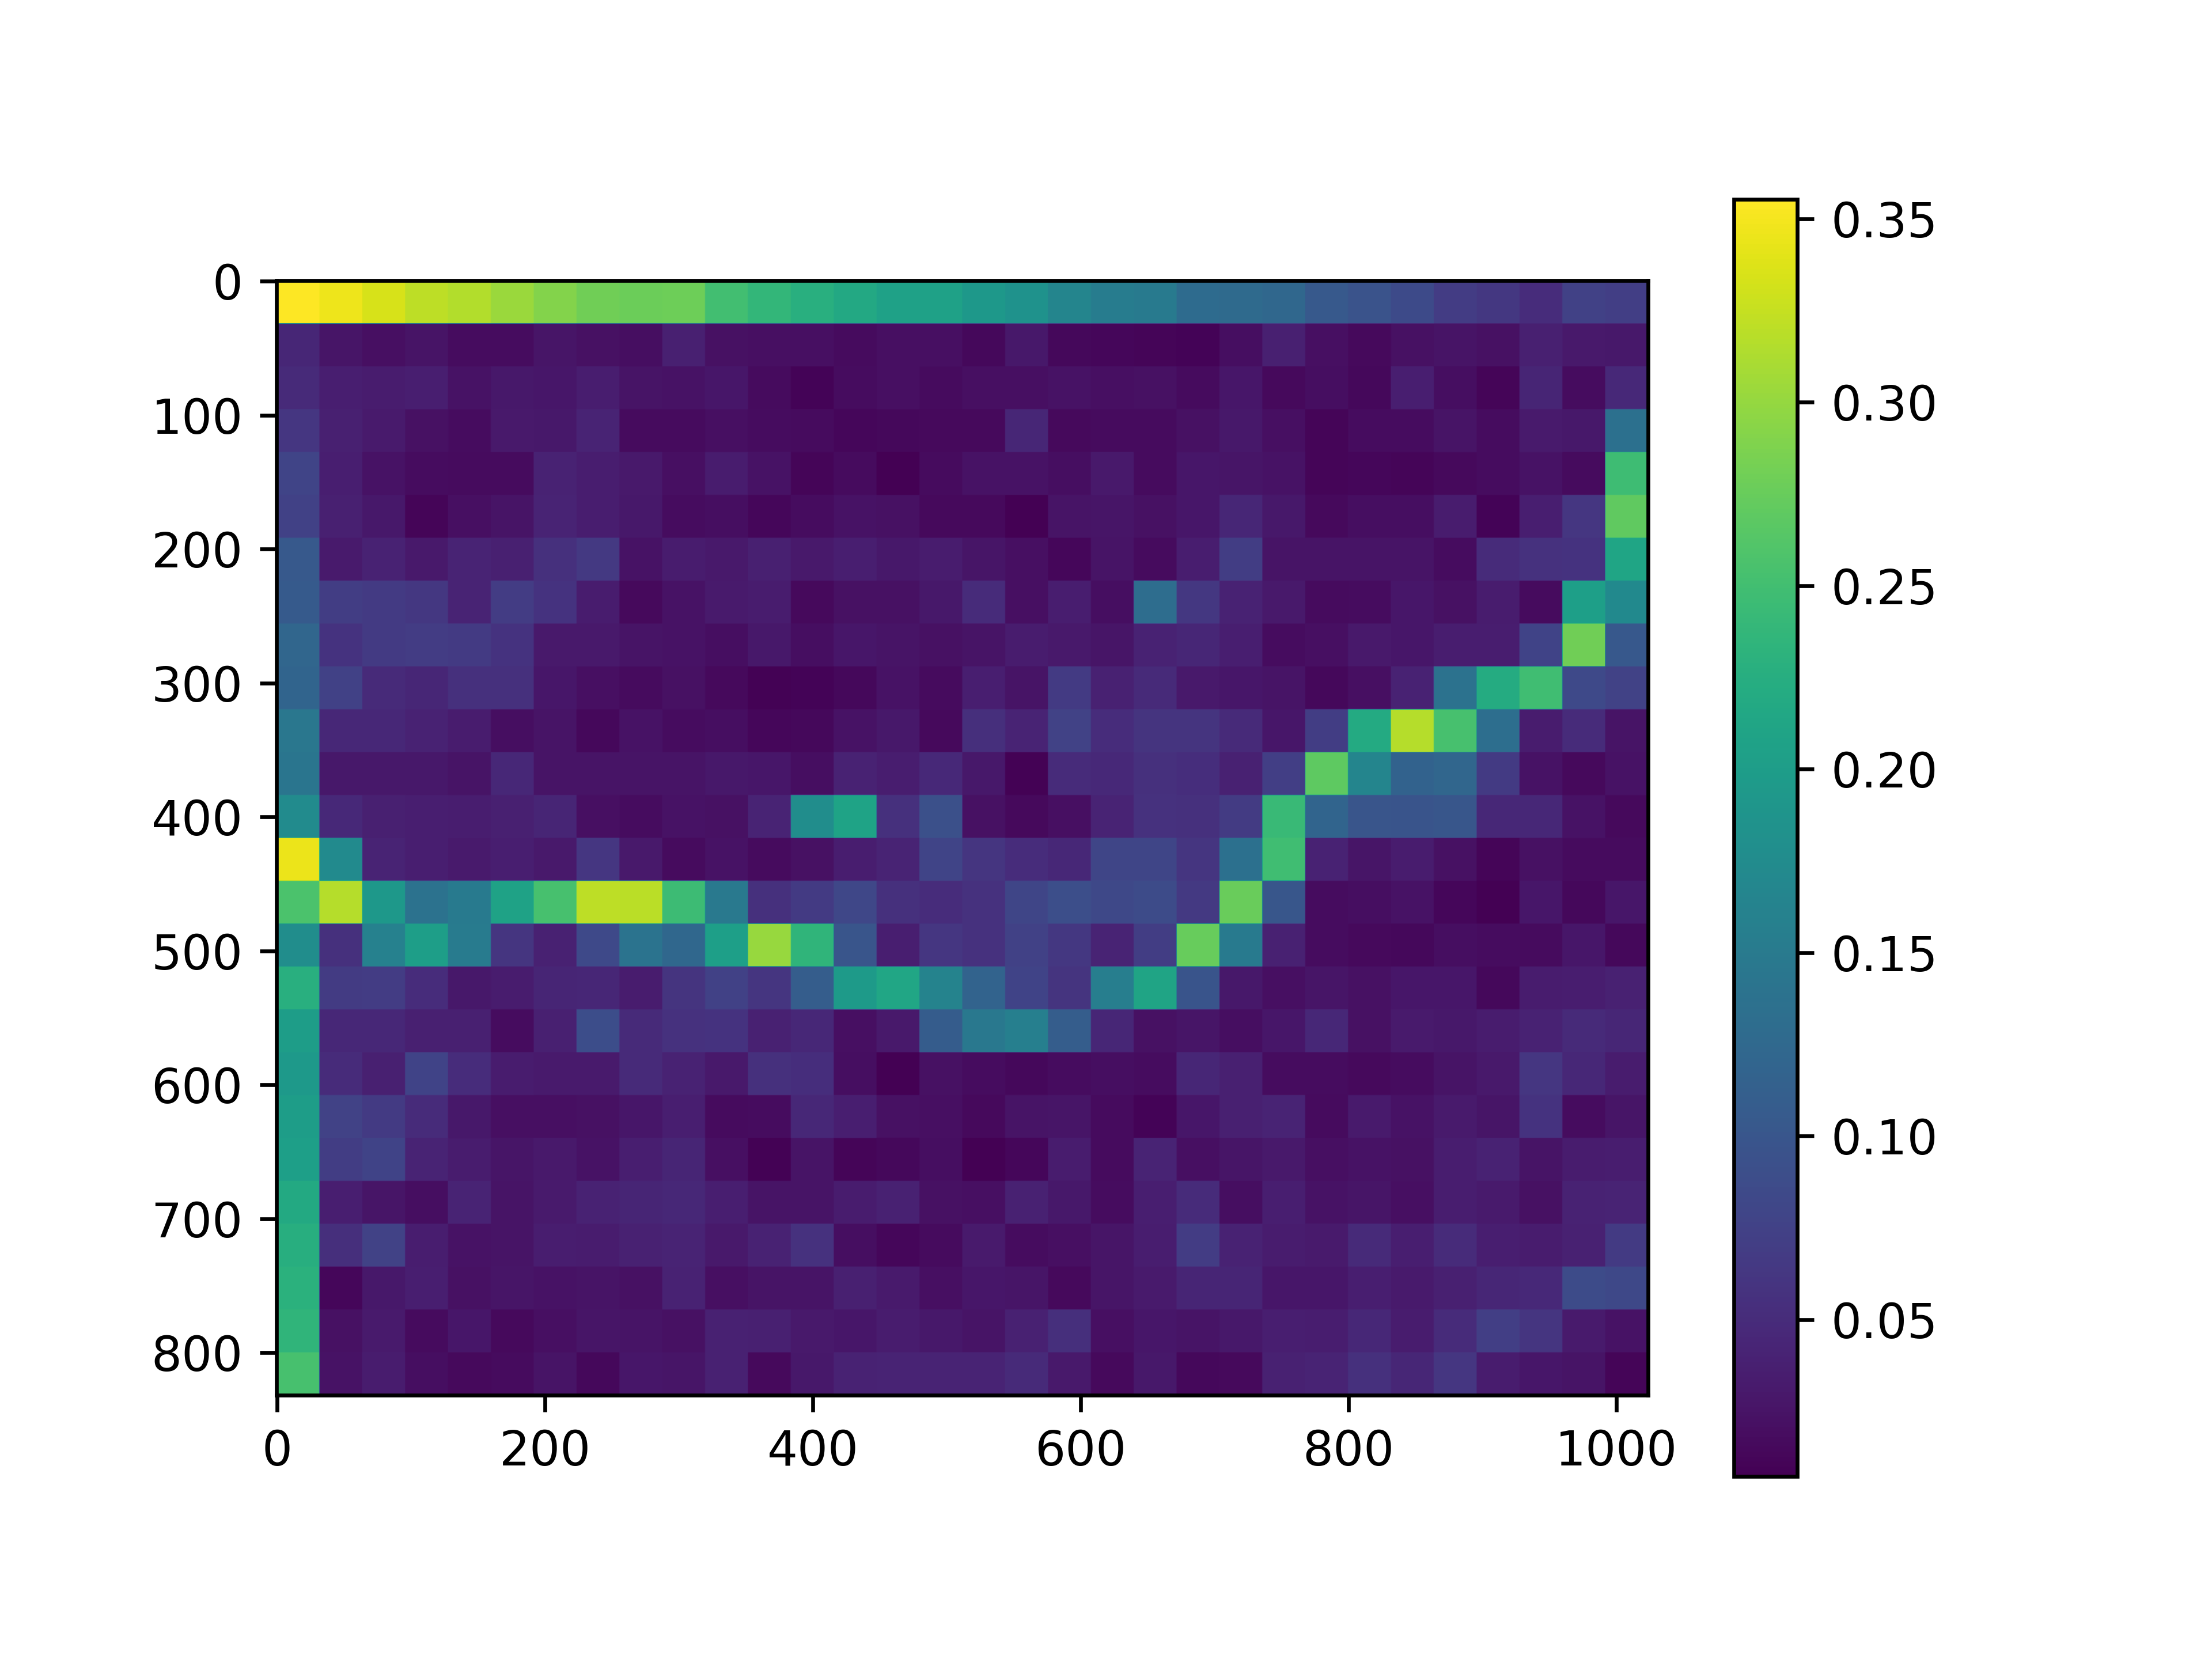

In [ ]:
# Event visualization
from IPython.display import Image
print('Baseline (pixel values in cosine distance, with memory 3)')
Image("./outputs/"+str(index).zfill(3)+"_10_cos_pixel | memory 3 | 32x32 - mean.png",
      height=400)

RAVAEN (cosine distance of learned embedded tiles, with memory 3)


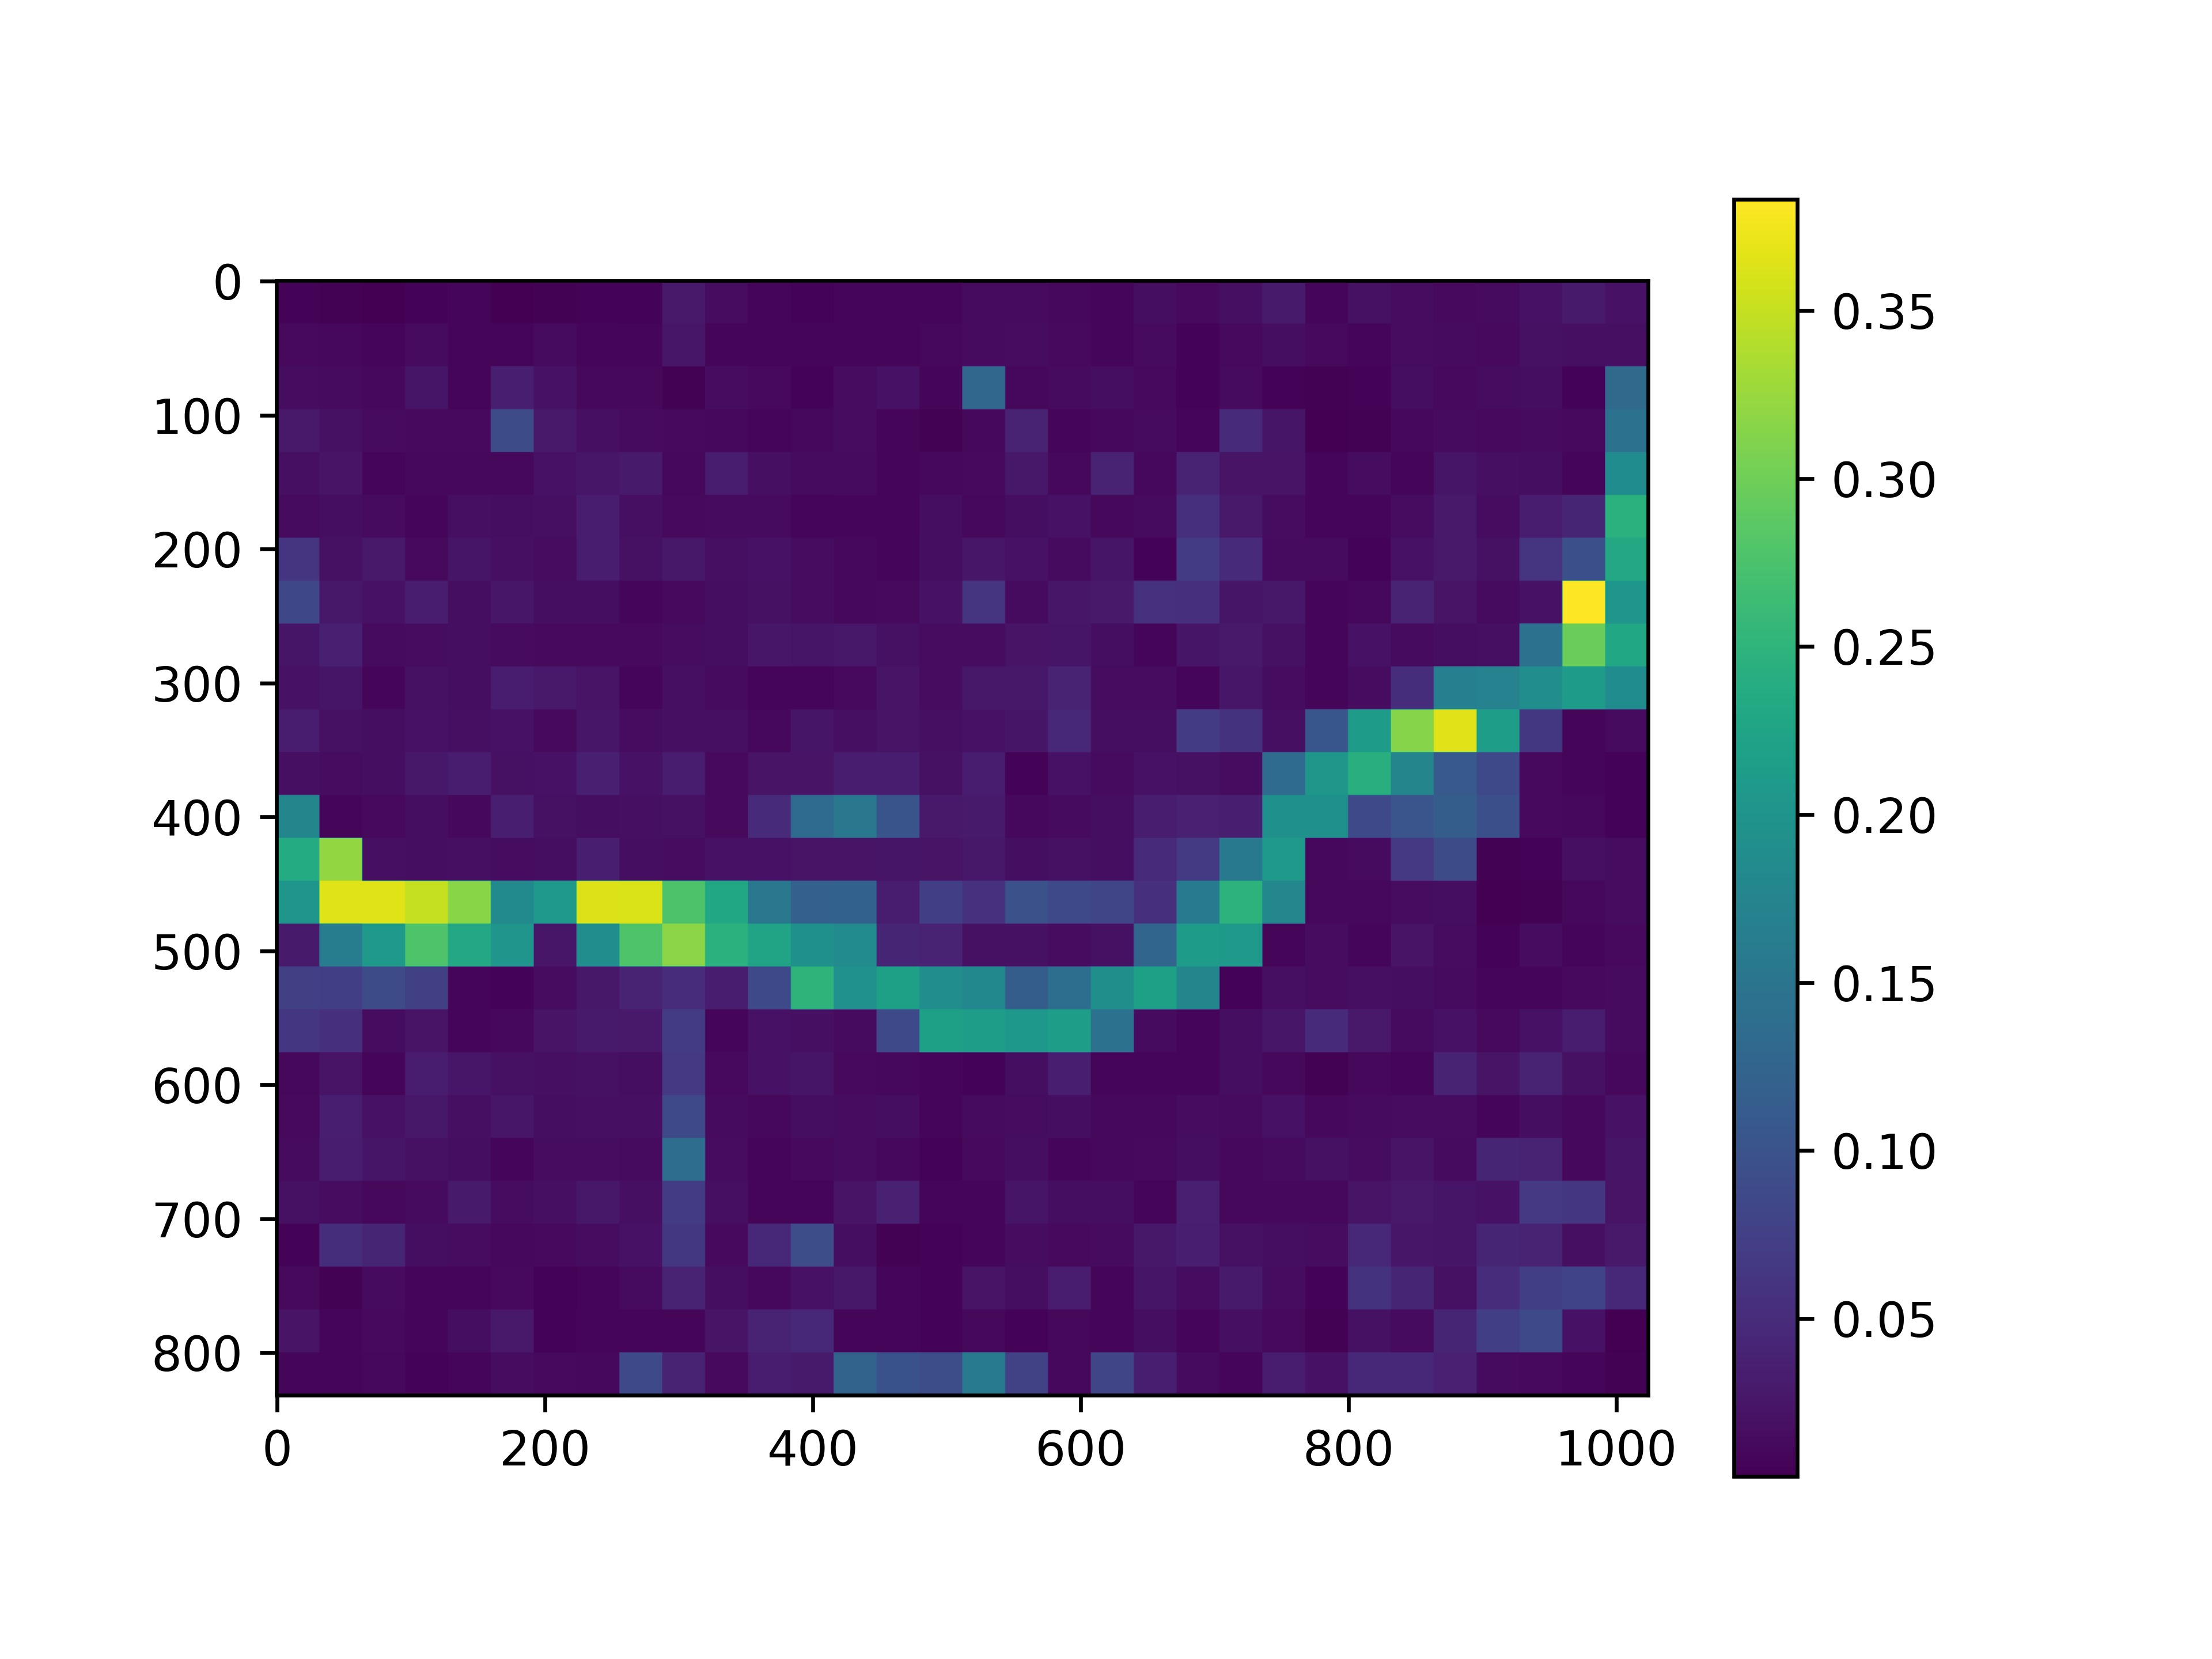

In [ ]:
print('RAVAEN (cosine distance of learned embedded tiles, with memory 3)')
Image("./outputs/"+str(index).zfill(3)+"_11_cos_emb | memory 3 | 32x32 - mean.png",
      height=400)

Quantitative results are also available, if we used real GT image.

In [ ]:
# import pandas as pd 
# df=pd.read_csv("./outputs/"+str(index).zfill(3)+"_stats.csv")
# df